# Evolve - evolution simulation

A much simplified version of this rad thing I saw on YouTube [I programed some creatures. They Evolved.](https://youtu.be/N3tRFayqVtk)

Blobs are created with some combination of senses and actions. Blobs may sense and move up, down, left and right. Blobs also have a multi-layer perceptron brain to process input signals to action signals. All of these attributes are determined by an 8-bit ingeger assigned at birth.

When mating, the new Blob will inherit half of it's genes from each parent.

Blobs are periodically trained to respond more strongly to higher concentrations of Blobs nearby.

Blobs only find each other and mate. They have no other abilities or drives.

We create a square grid, Blobland, to host a population Blobs. After so many steps of moving around and mating, all Blobs not in the safe zone are killed. The remaining are dispersed throughout Blobland, and new Blobs are added to replenish the population to the initial setting.

As each epoch completes, statistics about survival and mating opportunities are printed. 

After the chosen number of epoch completes an animation of each epoch may be viewed, along with a histogram relating genetic diversity of the surviving blobs.

Use the slider, rather than the play button, for smo0th animations.

**If a simulation seems to be going nowhere, you can stop with the stop button above and still view an animation of completed epochs**


In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from collections import defaultdict
from random import randint, random, sample
from datetime import datetime

## Settings

In [114]:
WORLD_EPOCHS = 100
STEPS_PER_WORLD_EPOCH = 150
SCENARIO = 'top' # 'corner', 'sides', 'left_side', 'right_side', 'top', 'bottom', 'interior'
SAFE_ZONE_SIZE = 5
INITIAL_POPULATION = 100

In [103]:
# You can mess with these, too. Just be careful. 
WORLD_SIZE = 100
STEPS_BETWEEN_TRAINING = 10
LEARNING_EPOCHS = 50
LEARNING_RATE = 1
PEAK_POPULATION = 1.5  # Multiple of INITIAL_POPULATION 
MATING_CHANCE = 0.15
MUTATION_CHANCE = 0.001
WORLD_INPUT_THRESHOLD = 0.5
TRAINING_INPUT_THRESHOLD = 0.6
SENSE_DISTANCE = 10
PLOT_DATA_SAVE_MOD = STEPS_PER_WORLD_EPOCH // 50

In [104]:
class Brain(object):
    def __init__(
        self,
        epochs=LEARNING_EPOCHS,
        learning_rate=LEARNING_RATE,
        n_input=3,
        n_hidden=4,
        n_out=1,
    ):
        # Initialize hyperparameter variables.
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.errors = []

        # Initialize weights and biases.
        self.hidden_weight = np.random.random(size=(self.n_input + 1, self.n_hidden))
        self.output_weight = np.random.random(size=(self.n_hidden + 1, self.n_out))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_prime(self, x):
        return x * (1 - x)

    def fit(self, features, labels):
        for _ in range(self.epochs):
            out = self.predict(features)
            self.backpass(features, labels, out)

    def backpass(self, features, labels, out):
        labels = np.array(labels)
        features = np.array(features)
        error = labels - out

        self.errors.append(np.sum(error ** 2))
        # Calculate adjustment from hidden -> output.
        delta_output = self.sigmoid_prime(out) * error

        # Calculate error from input -> hidden.
        output_error = delta_output.dot(self.output_weight[1:].T)
        delta_hidden = output_error.sum(axis=1).reshape(
            output_error.shape[0], 1
        ) * self.sigmoid_prime(out)

        # Adjust hidden -> output weights.

        self.output_weight[1:] += (
            self.activated_hidden.T.dot(delta_output) * self.learning_rate
        )
        self.output_weight[0] = np.sum(delta_output)
        self.hidden_weight[1:] += (
            features.T.dot(delta_hidden).mean(axis=1).reshape(self.n_input, 1)
            * self.learning_rate
        )
        self.hidden_weight[0] = np.sum(delta_hidden)

    def predict(self, features):
        inputs = np.dot(features, self.hidden_weight[1:]) + self.hidden_weight[0]
        self.activated_hidden = self.sigmoid(inputs)
        output = (
            np.dot(self.activated_hidden, self.output_weight[1:])
            + self.output_weight[0]
        )
        final = self.sigmoid(output)
        return final


In [129]:
class Blob:
    """An inhabitant of Blobland.

    Just a simple Blob who may, or may not, be able to look up, down, left or right in search of mates.
    Who similarly may, or may not, be able to move up, down, left, or right in pursuit of mates.
    Who possesses a multi-layer perceptron brain that may, or may not, effectively translate sense to motion.
    Sense, movement and brain configuration are determined by an 8-bit integer 'genome'.

    """

    def __init__(self, blobland, genome: int, mutant: bool = False):
        self.genome = f"{genome:08b}"[:8]
        self.blobland = blobland
        self.action_map = {
            0: self.move_up,
            1: self.move_down,
            2: self.move_left,
            3: self.move_right,
        }
        self.sense_map = {
            0: self.look_up,
            1: self.look_down,
            2: self.look_left,
            3: self.look_right,
        }
        self.senses = None
        # self.sense_distance = int(self.genome[3:7])
        self.actions = None
        self.brain = self.create_brain()
        self.pos = None
        self.survived = 0
        self.mated = 0
        self.training_inputs = None
        self.training_labels = []
        self.mutant = mutant
        self.spawn()

    def create_training_data(self):
        """Make training data for Blobs.
        Labels input signals > TRAINING_INPUT_THRESHOLD as 1 else 0
        """
        self.training_inputs = [
            [random() for _ in range(self.brain.n_input)] for _ in range(5)
        ]
        for training_input in self.training_inputs:
            self.training_labels.append(
                [
                    input_ > TRAINING_INPUT_THRESHOLD
                    for input_ in training_input[: self.brain.n_out]
                ]
                + [randint(0, 1) for _ in range(self.brain.n_out - self.brain.n_input)]
            )

    def create_brain(self) -> Brain:
        """Parses genome to create multi-layer perceptron Brain.

        Takes first 4 bits to encode senses according to sense_map.
        Takes last 4 bits to encode movement according to action_map.
        Takes middle 4 bits to encode number of hidden layers in Brain.
        """
        self.senses = [
            self.sense_map[i] for i, x in enumerate(self.genome[:4]) if x == "1"
        ]
        num_inputs = len(self.senses)
        hidden = int(self.genome[2:6], base=2)
        self.actions = [
            self.action_map[i] for i, x in enumerate(self.genome[4:]) if x == "1"
        ]
        num_outputs = len(self.actions)
        return Brain(
            n_input=num_inputs if num_inputs else 1,
            n_hidden=hidden if hidden else 1,
            n_out=num_outputs,
        )

    def find_mate(self):
        """Look one square up, down, left, and right. Attempt to mate with all."""
        for up_down, left_right in zip([1, -1, 0, 0], [0, 0, 1, -1]):
            adjacent_pos = (self.pos[0] + up_down, self.pos[1] + left_right)
            if adjacent_pos in self.blobland.blobs:
                self.mate(self.blobland.blobs[adjacent_pos])

    def mate(self, other):
        """Create new genome taking half from self and half from other.

        Mate and mutate according to settings.
        """
        chance = random()
        if self.survived and chance < MATING_CHANCE:
            mutant = False
            egg = self.genome[:4]
            sperm = other.genome[4:]
            fertilized = int(egg + sperm, base=2)
            if chance < MUTATION_CHANCE:
                # print('Mutation!!')
                mutate = 1 << randint(0, 8)
                fertilized ^= mutate
                mutant = True
            self.mated += 1
            self.blobland.add_blob(Blob(self.blobland, genome=fertilized, mutant=mutant))

    def spawn(self) -> None:
        """ Place this Blob in a random free space."""
        while True:
            pos = (randint(0, WORLD_SIZE - 1), randint(0, WORLD_SIZE - 1))
            if self.check_move(pos):
                self.update_position(pos)
                break

    def update_position(self, pos: tuple) -> None:
        if self.pos in self.blobland.blobs:
            del self.blobland.blobs[self.pos]
        self.pos = pos
        self.blobland.blobs[self.pos] = self

    def move_up(self, signal: float) -> None:
        if signal >= WORLD_INPUT_THRESHOLD:
            temp = list(self.pos)
            temp[0] += 1
            temp = tuple(temp)
            if self.check_move(temp):
                self.update_position(temp)

    def move_down(self, signal: float) -> None:
        if signal >= WORLD_INPUT_THRESHOLD:
            temp = list(self.pos)
            temp[0] -= 1
            temp = tuple(temp)
            if self.check_move(temp):
                self.update_position(temp)

    def move_left(self, signal: float) -> None:
        if signal >= WORLD_INPUT_THRESHOLD:
            temp = list(self.pos)
            temp[1] -= 1
            temp = tuple(temp)
            if self.check_move(temp):
                self.update_position(temp)

    def move_right(self, signal: float) -> None:
        if signal >= WORLD_INPUT_THRESHOLD:
            temp = list(self.pos)
            temp[1] += 1
            temp = tuple(temp)
            if self.check_move(temp):
                self.update_position(temp)

    def check_move(self, position) -> bool:
        """Ensure position is free and within Blobland."""
        row, col = position
        return (
            not (row, col) in self.blobland.blobs
            and 0 <= row < WORLD_SIZE
            and 0 <= col < WORLD_SIZE
        )

    def look(self, row_range: range, column_range: range) -> float:
        """Look a direction determined by row_range and column_range.

        Return population of blobs found relative to total population.
        """
        output = 0
        for row in row_range:
            if not 0 <= self.pos[0] + row < WORLD_SIZE:
                continue
            for column in column_range:
                if not 0 <= self.pos[1] + column < WORLD_SIZE:
                    continue
                if (self.pos[0] + row, self.pos[1] + column) in self.blobland.blobs:
                    output += 1
        return output / self.blobland.population

    def look_up(self) -> float:
        row_range = range(SENSE_DISTANCE)
        column_range = range(-SENSE_DISTANCE, SENSE_DISTANCE)
        return self.look(row_range, column_range)

    def look_down(self) -> float:
        row_range = range(-SENSE_DISTANCE, 0)
        column_range = range(-SENSE_DISTANCE, SENSE_DISTANCE)
        return self.look(row_range, column_range)

    def look_left(self) -> float:
        row_range = range(-SENSE_DISTANCE, SENSE_DISTANCE)
        column_range = range(-SENSE_DISTANCE, 0)
        return self.look(row_range, column_range)

    def look_right(self) -> float:
        row_range = range(-SENSE_DISTANCE, SENSE_DISTANCE)
        column_range = range(SENSE_DISTANCE)
        return self.look(row_range, column_range)

    def update(self):
        """Map sense input signals to actions."""
        input_signals = [sense() for sense in self.senses]
        if input_signals:
            output_signals = self.brain.predict(input_signals)
            for output, output_signal in zip(self.actions, output_signals):
                output(output_signal)

    def train(self):
        """Train all surviving Blobs with any senses plus any actions."""
        if self.survived and self.senses and self.brain.n_out:
            self.training_inputs, self.training_labels = [], []
            self.create_training_data()
            self.brain.fit(self.training_inputs, self.training_labels)


In [130]:
class Blobland:
    """A land for Blobs.

    A square grid of size world_size where Blobs may find each other, mate, and perhaps survive to the next epoch.

    """

    def __init__(self):
        self.population = 0
        self.blobs = {}
        self.data = defaultdict(list)
        self.peak = 0
        self.epoch_peak = 0

    def add_blob(self, blob: Blob) -> None:
        """Inhabitants are tracked by position in a dictionary.
        Increment population
        """
        self.blobs[blob.pos] = blob
        self.population += 1
        self.peak = max(self.peak, self.population)
        self.epoch_peak = max(self.epoch_peak, self.population)

    def cull(self, epoch, step) -> None:
        """Remove Blobs not in the safe zone determined by SCENARIO in settings.py.
        Reset population.
        Save data post culling.
        """
        keepers = {}
        if SCENARIO == "interior":
            keepers = {
                blob.pos: blob
                for blob in self.blobs.values()
                if blob.pos[0] in range(SAFE_ZONE_SIZE, WORLD_SIZE - SAFE_ZONE_SIZE + 1)
                   and blob.pos[1] in range(SAFE_ZONE_SIZE, WORLD_SIZE - SAFE_ZONE_SIZE + 1)
            }
        if SCENARIO == "bottom":
            keepers = {
                blob.pos: blob
                for blob in self.blobs.values()
                if blob.pos[0] in range(SAFE_ZONE_SIZE + 1)
            }
        if SCENARIO == "top":
            keepers = {
                blob.pos: blob
                for blob in self.blobs.values()
                if blob.pos[0] in range(WORLD_SIZE - SAFE_ZONE_SIZE, WORLD_SIZE + 1)
            }
        if SCENARIO == "left_side":
            keepers = {
                blob.pos: blob
                for blob in self.blobs.values()
                if blob.pos[1] in range(SAFE_ZONE_SIZE + 1)
            }
        if SCENARIO == "corner":
            keepers = {
                blob.pos: blob
                for blob in self.blobs.values()
                if blob.pos[0] in range(SAFE_ZONE_SIZE + 1)
                and blob.pos[1] in range(SAFE_ZONE_SIZE + 1)
            }
        if SCENARIO == "sides":
            keepers = {
                blob.pos: blob
                for blob in self.blobs.values()
                if blob.pos[1] in range(SAFE_ZONE_SIZE + 1)
                or blob.pos[1] in range(WORLD_SIZE - SAFE_ZONE_SIZE, WORLD_SIZE + 1)
            }
        if SCENARIO == "right_side":
            keepers = {
                blob.pos: blob
                for blob in self.blobs.values()
                if blob.pos[1] in range(WORLD_SIZE - SAFE_ZONE_SIZE, WORLD_SIZE + 1)
            }
        if not keepers:
            raise ValueError(f"Check SCENARIO in settings.py. You entered {SCENARIO}.")
        self.population = len(keepers)
        self.blobs.clear()
        self.blobs = keepers
        for blob in self.blobs.values():
            self.save_step_data(epoch, step + 1, blob)

    def update(self, epoch: int = 0, start_time: datetime = None) -> None:
        """Reset population.
        If epoch end:
            - increment survival count
            - allow each Blob to mate
            - spawn each Blob
            - print epoch stats to stdout.
        """
        end_time = datetime.now()
        self.population = len(self.blobs)
        repeat_survivors, ultimate_survivor = 0, 0
        ultimate_fucker, mated, mutants = 0, 0, 0
        gene_pool = set()
        blobs = list(self.blobs.values())
        for blob in blobs:
            blob.survived += 1
            blob.find_mate()
            blob.spawn()
            mated += blob.mated > 0
            repeat_survivors += blob.survived > 1
            ultimate_survivor = max(ultimate_survivor, blob.survived)
            ultimate_fucker = max(ultimate_fucker, blob.mated)
            mutants += blob.mutant
            gene_pool.add(blob.genome)
        print(
            f"EPOCH: {epoch}\tepoch time {(end_time - start_time).seconds} seconds\nsurviving population {self.population}\tpeak population {self.peak}\tepoch peak {self.epoch_peak}\tsurviving proportion {self.population / self.epoch_peak:.2f}"
        )
        print(
            f"repeats {repeat_survivors}\ttotal mated {mated}\tsurviving gene pool {len(gene_pool)}\noldest survivor {ultimate_survivor}\tUltimate fucker {ultimate_fucker}\ttotal mutants {mutants}\n"
        )

    def manage_population(self):
        """Repopulate up to initial population setting.
        If population has more than doubled initial setting, cull to doubled.
        Option to slice population keeping the oldest members, or keep a random selection.
        """
        for _ in range(INITIAL_POPULATION - self.population):
            self.add_blob(Blob(blobland=self, genome=randint(0, 255)))

        if self.population >= 2 * INITIAL_POPULATION:
            # self.blobs = dict(
            #     sample(list(self.blobs.items()), INITIAL_POPULATION * 2)  # Equal opportunity
            # )
            self.blobs = dict(
                list(self.blobs.items())[: INITIAL_POPULATION * 2]  # Genetic Domination
            )
        self.population = len(self.blobs)

    def cleanup_epoch(self, epoch: int, step: int, start_time: datetime) -> None:
        """Call end of epoch functions."""
        self.cull(epoch, step)
        self.update(epoch, start_time=start_time)

    def save_step_data(self, epoch: int, step: int, blob: Blob) -> None:
        """Records data from step in data dictionary."""
        if step % PLOT_DATA_SAVE_MOD == 0:
            self.data["epoch"].append(epoch)
            self.data["step"].append(step)
            self.data["x"].append(blob.pos[1])
            self.data["y"].append(blob.pos[0])
            self.data["genome"].append(int(blob.genome, base=2))
            self.data["string_genome"].append(str(int(blob.genome, base=2)))

    def animate_epoch(self, epoch: int) -> None:
        """Create animated scatter plot of epoch steps and histogram of genomes."""
        df = pd.DataFrame.from_dict(self.data)
        df = df[df["epoch"] == epoch]
        scatter = px.scatter(
            data_frame=df,
            x="x",
            y="y",
            animation_frame="step",
            color="string_genome",
            range_x=[-1, WORLD_SIZE + 1],
            range_y=[-1, WORLD_SIZE + 1],
            height=800,
            width=800,
            title=f"Epoch {epoch}",
            color_discrete_sequence=px.colors.qualitative.Antique,
        )
        if SCENARIO == "interior":
            scatter.add_shape(
                type="line",
                x0=SAFE_ZONE_SIZE,
                y0=SAFE_ZONE_SIZE,
                x1=SAFE_ZONE_SIZE,
                y1=WORLD_SIZE - SAFE_ZONE_SIZE,
                line=dict(width=1, dash="solid"),
            )
            scatter.add_shape(
                type="line",
                x0=SAFE_ZONE_SIZE,
                y0=WORLD_SIZE - SAFE_ZONE_SIZE,
                x1=WORLD_SIZE - SAFE_ZONE_SIZE,
                y1=WORLD_SIZE - SAFE_ZONE_SIZE,
                line=dict(width=1, dash="solid"),
            )
            scatter.add_shape(
                type="line",
                x0=WORLD_SIZE - SAFE_ZONE_SIZE,
                y0=WORLD_SIZE - SAFE_ZONE_SIZE,
                x1=WORLD_SIZE - SAFE_ZONE_SIZE,
                y1=SAFE_ZONE_SIZE,
                line=dict(width=1, dash="solid"),
            )
            scatter.add_shape(
                type="line",
                x0=SAFE_ZONE_SIZE,
                y0=SAFE_ZONE_SIZE,
                x1=WORLD_SIZE - SAFE_ZONE_SIZE,
                y1=SAFE_ZONE_SIZE,
                line=dict(width=1, dash="solid"),
            )
        if SCENARIO == "bottom":
            scatter.add_shape(
                type="line",
                x0=0,
                y0=SAFE_ZONE_SIZE,
                x1=WORLD_SIZE,
                y1=SAFE_ZONE_SIZE,
                line=dict(width=1, dash="solid"),
            )
        if SCENARIO == "top":
            scatter.add_shape(
                type="line",
                x0=0,
                y0=WORLD_SIZE - SAFE_ZONE_SIZE,
                x1=WORLD_SIZE,
                y1=WORLD_SIZE - SAFE_ZONE_SIZE,
                line=dict(width=1, dash="solid"),
            )
        if SCENARIO == "sides":
            scatter.add_shape(
                type="line",
                x0=SAFE_ZONE_SIZE,
                y0=0,
                x1=SAFE_ZONE_SIZE,
                y1=WORLD_SIZE,
                line=dict(width=1, dash="solid"),
            )
            scatter.add_shape(
                type="line",
                x0=WORLD_SIZE - SAFE_ZONE_SIZE,
                y0=0,
                x1=WORLD_SIZE - SAFE_ZONE_SIZE,
                y1=WORLD_SIZE,
                line=dict(width=1, dash="solid"),
            )
        if SCENARIO == "corner":
            scatter.add_shape(
                type="line",
                x0=SAFE_ZONE_SIZE,
                y0=0,
                x1=SAFE_ZONE_SIZE,
                y1=SAFE_ZONE_SIZE,
                line=dict(width=1, dash="solid"),
            )
            scatter.add_shape(
                type="line",
                x0=0,
                y0=SAFE_ZONE_SIZE,
                x1=SAFE_ZONE_SIZE,
                y1=SAFE_ZONE_SIZE,
                line=dict(width=1, dash="solid"),
            )
        if SCENARIO == "left_side":
            scatter.add_shape(
                type="line",
                x0=SAFE_ZONE_SIZE,
                y0=0,
                x1=SAFE_ZONE_SIZE,
                y1=WORLD_SIZE,
                line=dict(width=1, dash="solid"),
            )
        if SCENARIO == "right_side":
            scatter.add_shape(
                type="line",
                x0=WORLD_SIZE - SAFE_ZONE_SIZE,
                y0=0,
                x1=WORLD_SIZE - SAFE_ZONE_SIZE,
                y1=WORLD_SIZE,
                line=dict(width=1, dash="solid"),
            )
        scatter.update_xaxes(showgrid=False, showticklabels=False, visible=False)
        scatter.update_yaxes(showgrid=False, showticklabels=False, visible=False)
        scatter.show()
        hist = px.histogram(
            data_frame=df[(df["epoch"] == epoch) & (df["step"] == df["step"].max())],
            x="string_genome",
            y="string_genome",
            color="string_genome",
            nbins=df["string_genome"].nunique(),
            histfunc="count",
            height=400,
            width=800,
            title=f"Epoch {epoch} survivors",
            color_discrete_sequence=px.colors.qualitative.Antique,
        )
        hist.show()


In [131]:
def main():
    """Create a Blobland of Blobs and perform a simulation."""
    try:
        blobland = Blobland()
        for epoch in range(1, WORLD_EPOCHS + 1):
            blobland.epoch_peak = 0
            blobland.manage_population()
            epoch_start_time = datetime.now()
            for step in range(1, STEPS_PER_WORLD_EPOCH + 1):
                blobs = list(blobland.blobs.values())
                for blob in blobs:
                    if step % STEPS_BETWEEN_TRAINING == 0:
                        blob.train()
                        blob.find_mate()
                    blob.update()
                    blobland.save_step_data(epoch, step, blob)
            blobland.cleanup_epoch(epoch, step, epoch_start_time)
    except KeyboardInterrupt:
        return blobland
    return blobland

In [132]:
if __name__ == '__main__':
    world = main()

EPOCH: 1	epoch time 0 seconds
surviving population 13	peak population 100	epoch peak 100	surviving proportion 0.13
repeats 0	total mated 1	surviving gene pool 12
oldest survivor 1	Ultimate fucker 1	total mutants 0

EPOCH: 2	epoch time 1 seconds
surviving population 24	peak population 111	epoch peak 111	surviving proportion 0.22
repeats 4	total mated 4	surviving gene pool 18
oldest survivor 2	Ultimate fucker 3	total mutants 0

EPOCH: 3	epoch time 1 seconds
surviving population 46	peak population 128	epoch peak 128	surviving proportion 0.36
repeats 13	total mated 13	surviving gene pool 31
oldest survivor 3	Ultimate fucker 5	total mutants 0



/tmp/ipykernel_469/2412399389.py:23: RuntimeWarning:

overflow encountered in exp



EPOCH: 4	epoch time 1 seconds
surviving population 38	peak population 135	epoch peak 135	surviving proportion 0.28
repeats 13	total mated 11	surviving gene pool 26
oldest survivor 4	Ultimate fucker 5	total mutants 0

EPOCH: 5	epoch time 1 seconds
surviving population 38	peak population 138	epoch peak 138	surviving proportion 0.28
repeats 12	total mated 11	surviving gene pool 25
oldest survivor 5	Ultimate fucker 7	total mutants 0

EPOCH: 6	epoch time 1 seconds
surviving population 32	peak population 138	epoch peak 119	surviving proportion 0.27
repeats 11	total mated 8	surviving gene pool 25
oldest survivor 6	Ultimate fucker 8	total mutants 0

EPOCH: 7	epoch time 1 seconds
surviving population 39	peak population 138	epoch peak 126	surviving proportion 0.31
repeats 11	total mated 10	surviving gene pool 26
oldest survivor 7	Ultimate fucker 12	total mutants 1

EPOCH: 8	epoch time 1 seconds
surviving population 49	peak population 138	epoch peak 135	surviving proportion 0.36
repeats 17	total 

#### Use the slider, rather than the play button, for smooth animations.

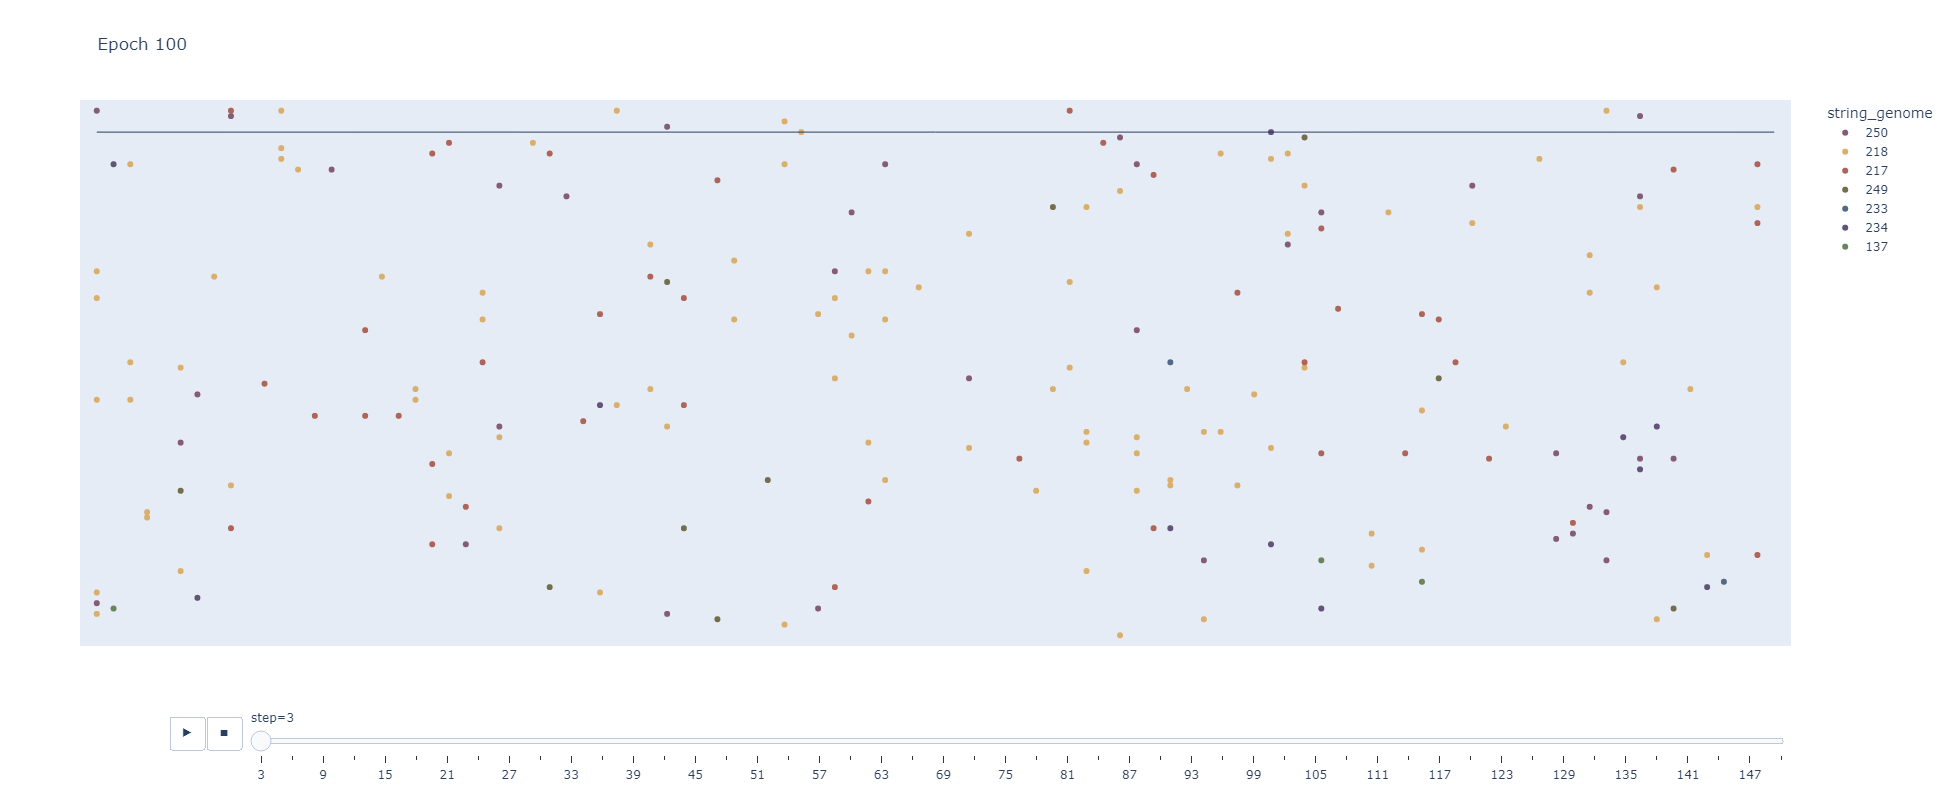

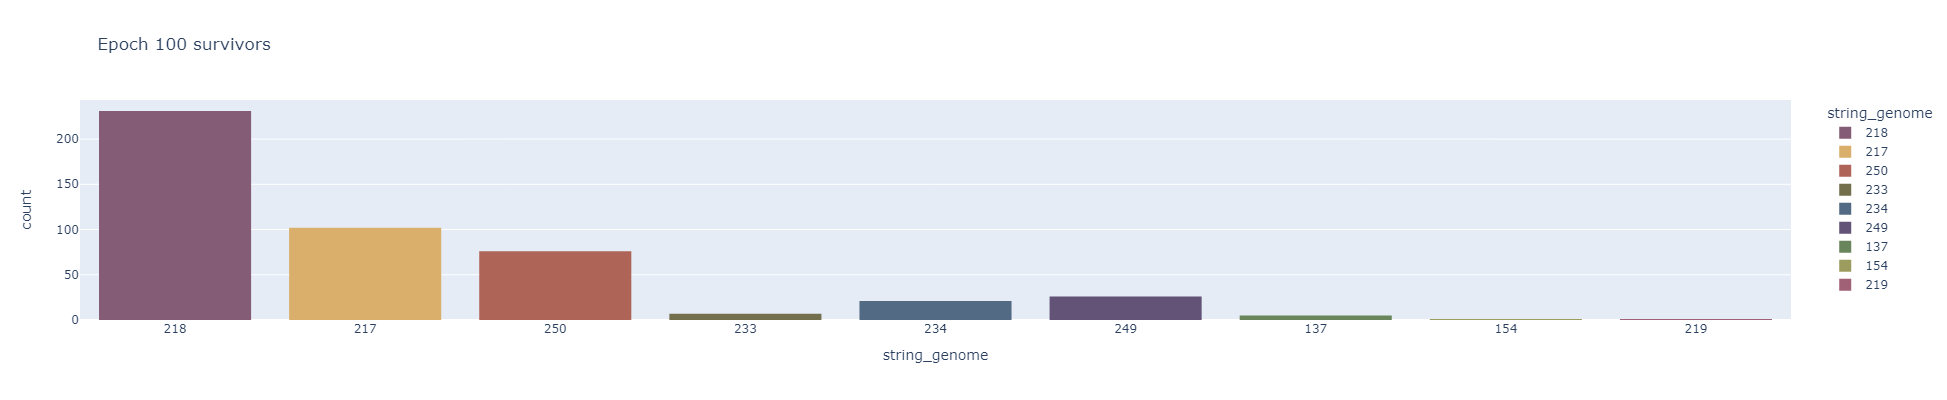

In [135]:
world.animate_epoch(100)